Using device: cuda (Training on DOG image)
Training on Dog Image...
Step 0: Loss 3419.62
Step 200: Loss 326.55
Visualizing...


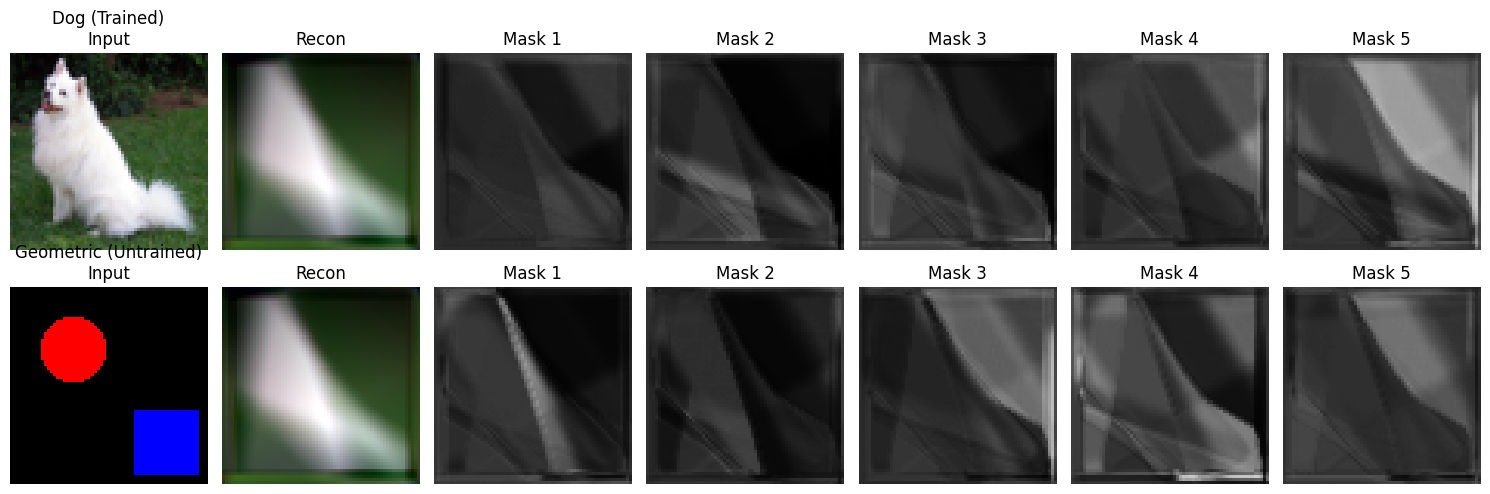

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# ==========================================
# 1. データセット: 「犬の画像1枚」だけをひたすら返す
# ==========================================
class SingleDogDataset(Dataset):
    def __init__(self, resolution=(64, 64), length=10000):
        self.resolution = resolution
        self.length = length
        self.img_tensor = self._load_dog_image()

    def _load_dog_image(self):
        # ネット接続がない場合はノイズ、ある場合は犬
        url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img = img.resize(self.resolution)
            return transforms.ToTensor()(img)
        except:
            print("Download failed. Using noise.")
            return torch.randn(3, *self.resolution).abs().clip(0, 1)

    def __getitem__(self, idx):
        # 常に同じ画像を返す（過学習させるため）
        return self.img_tensor

    def __len__(self):
        return self.length

# ==========================================
# 2. Slot Attention & Model (変更なし)
# ==========================================
# ※ 先ほどの定義と同じものを使いますが、念のため再掲します
class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters=3, hidden_dim=64):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.scale = dim ** -0.5
        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)
        self.gru = nn.GRUCell(dim, dim)
        self.norm_input = nn.LayerNorm(dim)
        self.norm_slots = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(inplace=True), nn.Linear(hidden_dim, dim)
        )

    def forward(self, inputs, current_temp, num_slots=None):
        b, n, d = inputs.shape
        n_s = num_slots if num_slots is not None else self.num_slots
        inputs = self.norm_input(inputs)
        slots = torch.randn(b, n_s, d, device=inputs.device) # Random Init
        k = self.to_k(inputs)
        v = self.to_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots
            slots = self.norm_slots(slots)
            q = self.to_q(slots)
            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            attn = (dots / current_temp).softmax(dim=1) + 1e-8
            attn_sum = attn.sum(dim=-1, keepdim=True)
            updates = torch.einsum('bjd,bij->bid', v, attn / attn_sum)
            slots = self.gru(updates.reshape(-1, d), slots_prev.reshape(-1, d))
            slots = slots.reshape(b, -1, d)
            slots = slots + self.mlp(self.norm_pre_ff(slots))
        return slots

class SlotModel(nn.Module):
    def __init__(self, resolution=(64, 64), num_slots=5, hidden_dim=32):
        super().__init__()
        self.resolution = resolution
        self.num_slots = num_slots
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(5, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, hidden_dim, 5, padding=2), nn.ReLU(), 
        )
        self.pos_emb = nn.Parameter(torch.randn(1, hidden_dim, resolution[0], resolution[1]) * 0.01)
        self.slot_attention = SlotAttention(num_slots, hidden_dim, iters=5, hidden_dim=64)
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim + 2, 32, 5, padding=2), nn.ReLU(), 
            nn.Conv2d(32, 32, 5, padding=2), nn.ReLU(),
            nn.Conv2d(32, 4, 3, padding=1),
        )

    def build_grid(self, batch_size, resolution, device):
        h, w = resolution
        x = torch.linspace(-1, 1, w, device=device)
        y = torch.linspace(-1, 1, h, device=device)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        grid = torch.stack((grid_x, grid_y), dim=0).unsqueeze(0).repeat(batch_size, 1, 1, 1)
        return grid

    def forward(self, x, current_temp):
        b, c, h, w = x.shape
        grid = self.build_grid(b, (h, w), x.device)
        x_with_grid = torch.cat([x, grid], dim=1)
        x_enc = self.encoder(x_with_grid) + self.pos_emb
        x_flat = x_enc.permute(0, 2, 3, 1).reshape(b, -1, self.hidden_dim)
        slots = self.slot_attention(x_flat, current_temp)
        slots_img = slots.view(b * self.num_slots, self.hidden_dim, 1, 1).repeat(1, 1, h, w)
        grid_flat = self.build_grid(b * self.num_slots, (h, w), x.device)
        out = self.decoder(torch.cat([slots_img, grid_flat], dim=1))
        out = out.view(b, self.num_slots, 4, h, w)
        recons = out[:, :, :3, :, :]
        masks = torch.softmax(out[:, :, 3:4, :, :] / current_temp, dim=1)
        return torch.sum(recons * masks, dim=1), recons, masks

# ==========================================
# 3. 実行パート: 犬を学習 -> 図形でテスト
# ==========================================
def run_dog_training():
    torch.manual_seed(42) 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device} (Training on DOG image)")

    # 犬データセット (1枚だけ)
    dataset = SingleDogDataset(length=10000) # 十分な回数回す
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Batch32で同じ画像を食わせる

    model = SlotModel(resolution=(64, 64), num_slots=5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001) # 少し強めの学習率

    print("Training on Dog Image...")
    model.train()
    
    total_steps = 1000
    start_temp = 1.0
    end_temp = 0.01

    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        progress = min(1.0, i / total_steps)
        current_temp = start_temp * (1 - progress) + end_temp * progress
        
        optimizer.zero_grad()
        recon, _, masks = model(batch, current_temp)
        loss = ((batch - recon)**2).sum()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        if i % 200 == 0:
            print(f"Step {i}: Loss {loss.item()/32:.2f}")
        
        if i >= total_steps:
            break

    # --------------------------
    # 比較表示
    # --------------------------
    print("Visualizing...")
    model.eval()

    # 1. 学習に使った「犬」 (Trained)
    img_dog = dataset[0].unsqueeze(0).to(device)
    
    # 2. 未学習の「図形」 (Untrained)
    # 簡易的に図形を生成
    from PIL import ImageDraw
    img_shape = Image.new("RGB", (64, 64), (0, 0, 0))
    draw = ImageDraw.Draw(img_shape)
    draw.ellipse((10, 10, 30, 30), fill=(255, 0, 0))
    draw.rectangle((40, 40, 60, 60), fill=(0, 0, 255))
    img_geom = transforms.ToTensor()(img_shape).unsqueeze(0).to(device)

    with torch.no_grad():
        recon_d, _, masks_d = model(img_dog, current_temp=0.01)
        recon_g, _, masks_g = model(img_geom, current_temp=0.01)

    # Plot
    def to_np(t): return t[0].permute(1, 2, 0).cpu().numpy().clip(0, 1)
    def mask_to_np(m): return m[0, :, 0].cpu().numpy()

    fig, axes = plt.subplots(2, 7, figsize=(15, 5))
    rows = ["Dog (Trained)", "Geometric (Untrained)"]
    pairs = [(img_dog, recon_d, masks_d), (img_geom, recon_g, masks_g)]

    for row_idx, (img, recon, masks) in enumerate(pairs):
        axes[row_idx, 0].imshow(to_np(img))
        axes[row_idx, 0].set_title(f"{rows[row_idx]}\nInput")
        axes[row_idx, 0].axis('off')
        
        axes[row_idx, 1].imshow(to_np(recon))
        axes[row_idx, 1].set_title("Recon")
        axes[row_idx, 1].axis('off')
        
        m_np = mask_to_np(masks)
        for k in range(5):
            axes[row_idx, k+2].imshow(m_np[k], cmap='gray', vmin=0, vmax=1)
            axes[row_idx, k+2].set_title(f"Mask {k+1}")
            axes[row_idx, k+2].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_dog_training()